In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

### 이미지를 텐서로 바꿔주는 코드

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### Fashion mnist

In [3]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

In [4]:
batch_size = 64

train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset= testset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

### 데이터 살펴보기 : 여러개

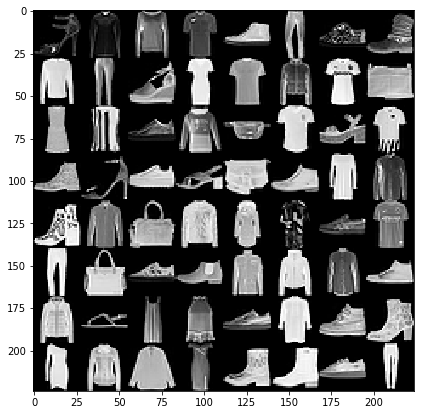

tensor([5, 6, 2, 0, 7, 1, 7, 9, 2, 1, 5, 3, 0, 4, 0, 8, 3, 0, 7, 2, 8, 0, 5, 0,
        9, 5, 7, 5, 8, 9, 3, 6, 9, 6, 8, 4, 4, 3, 7, 0, 1, 8, 7, 9, 4, 4, 6, 7,
        4, 5, 3, 6, 7, 6, 9, 9, 3, 6, 6, 3, 9, 9, 7, 1])


In [6]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
print(labels)


In [7]:

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [8]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

Sandal
Shirt
Pullover
T-shirt/top
Sneaker
Trouser
Sneaker
Ankle boot
Pullover
Trouser
Sandal
Dress
T-shirt/top
Coat
T-shirt/top
Bag
Dress
T-shirt/top
Sneaker
Pullover
Bag
T-shirt/top
Sandal
T-shirt/top
Ankle boot
Sandal
Sneaker
Sandal
Bag
Ankle boot
Dress
Shirt
Ankle boot
Shirt
Bag
Coat
Coat
Dress
Sneaker
T-shirt/top
Trouser
Bag
Sneaker
Ankle boot
Coat
Coat
Shirt
Sneaker
Coat
Sandal
Dress
Shirt
Sneaker
Shirt
Ankle boot
Ankle boot
Dress
Shirt
Shirt
Dress
Ankle boot
Ankle boot
Sneaker
Trouser


### 데이터 살펴보기 : 하나씩

(28, 28)


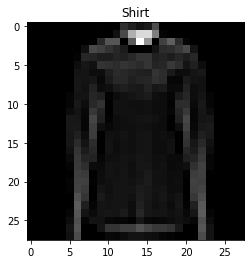

In [9]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 신경망

### 사용장치 선택

In [10]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## 뉴럴넷 구성

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,10)
        
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 모델 준비

In [12]:
model = Net().to(DEVICE) # 모델의 파라미터를 CPU나 GPU로 보냄
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 학습

In [13]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

### 테스트

In [14]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8521, Accuracy: 68.85%
[2] Test Loss: 0.6852, Accuracy: 75.15%
[3] Test Loss: 0.5745, Accuracy: 79.68%
[4] Test Loss: 0.5362, Accuracy: 81.04%
[5] Test Loss: 0.5197, Accuracy: 81.45%
[6] Test Loss: 0.5176, Accuracy: 81.52%
[7] Test Loss: 0.5225, Accuracy: 81.70%
[8] Test Loss: 0.4758, Accuracy: 83.02%
[9] Test Loss: 0.4634, Accuracy: 83.43%
[10] Test Loss: 0.4550, Accuracy: 83.64%
[11] Test Loss: 0.4525, Accuracy: 83.96%
[12] Test Loss: 0.4664, Accuracy: 82.95%
[13] Test Loss: 0.4337, Accuracy: 84.58%
[14] Test Loss: 0.4301, Accuracy: 84.76%
[15] Test Loss: 0.4352, Accuracy: 84.80%
[16] Test Loss: 0.4121, Accuracy: 85.34%
[17] Test Loss: 0.4155, Accuracy: 85.26%
[18] Test Loss: 0.4142, Accuracy: 85.38%
[19] Test Loss: 0.4128, Accuracy: 85.29%
[20] Test Loss: 0.4130, Accuracy: 85.63%
[21] Test Loss: 0.4058, Accuracy: 85.53%
[22] Test Loss: 0.3912, Accuracy: 86.11%
[23] Test Loss: 0.3904, Accuracy: 86.35%
[24] Test Loss: 0.3960, Accuracy: 85.79%
[25] Test Loss: 0.3825, A

In [17]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

## Drop out

In [18]:
EPOCHS = 50
BATCH_SIZE = 64

### 데이터셋에 노이즈 추가

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

100.1%

Extracting ./.data\MNIST\raw\train-images-idx3-ubyte.gz to ./.data\MNIST\raw


113.5%

Extracting ./.data\MNIST\raw\train-labels-idx1-ubyte.gz to ./.data\MNIST\raw


100.4%

Extracting ./.data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./.data\MNIST\raw


180.4%

Extracting ./.data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data\MNIST\raw
Processing...
Done!


### 뉴럴넷

In [20]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [21]:
model        = Net(dropout_p=0.2).to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

In [22]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [23]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 맞춘 갯수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [24]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.5440, Accuracy: 82.25%
[2] Test Loss: 0.4133, Accuracy: 87.23%
[3] Test Loss: 0.3369, Accuracy: 89.64%
[4] Test Loss: 0.2823, Accuracy: 91.35%
[5] Test Loss: 0.2428, Accuracy: 92.41%
[6] Test Loss: 0.2192, Accuracy: 93.14%
[7] Test Loss: 0.1999, Accuracy: 93.72%
[8] Test Loss: 0.1830, Accuracy: 94.28%
[9] Test Loss: 0.1762, Accuracy: 94.50%
[10] Test Loss: 0.1632, Accuracy: 94.86%
[11] Test Loss: 0.1569, Accuracy: 94.91%
[12] Test Loss: 0.1499, Accuracy: 95.31%
[13] Test Loss: 0.1448, Accuracy: 95.43%
[14] Test Loss: 0.1393, Accuracy: 95.60%
[15] Test Loss: 0.1334, Accuracy: 95.78%
[16] Test Loss: 0.1306, Accuracy: 95.80%
[17] Test Loss: 0.1259, Accuracy: 95.92%
[18] Test Loss: 0.1229, Accuracy: 96.11%
[19] Test Loss: 0.1187, Accuracy: 96.26%
[20] Test Loss: 0.1199, Accuracy: 96.19%
[21] Test Loss: 0.1151, Accuracy: 96.43%
[22] Test Loss: 0.1113, Accuracy: 96.43%
[23] Test Loss: 0.1091, Accuracy: 96.60%
[24] Test Loss: 0.1071, Accuracy: 96.63%
[25] Test Loss: 0.1070, A